In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
from keras.models import Model
from keras.layers import Embedding
from keras.optimizers import Adam

In [3]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

In [4]:
def train_test_split_user(ratings, test_size=0.2):
    train_list = []
    test_list = []

    # Get all unique users
    for user_id in ratings['userId'].unique():
        # Filter the dataset to include only rows corresponding to curr user
        user_data = ratings[ratings['userId'] == user_id]
        # Check if user has rated more than 5 movies to meaningfully split data into train and test
        # Ex. user with 10 ratings -> 8 train, 2 test, but user with 3 ratings -> 2 train, 1 test
            # In the latter case, we would not have enough data to train the model
        # If user has rated more than 5 movies, split the data into train and test
        # Else, include all data in train
        if len(user_data) >= 5:
            train_data, test_data = train_test_split(user_data, test_size=test_size, random_state=42)
            train_list.append(train_data)
            test_list.append(test_data)
        else:
            train_list.append(user_data)
    
    # Combine training and testing data for all users into train and test
    train = pd.concat(train_list)
    test = pd.concat(test_list)
    return train, test

train_data, test_data = train_test_split_user(ratings)
print(train_data.head())
# # We don't need timestamp column
# train_data = train_data.drop(columns=['timestamp'])
# test_data = test_data.drop(columns=['timestamp'])

     userId  movieId  rating  timestamp
55        1     1031     5.0  964982653
230       1     4006     4.0  964982903
69        1     1197     5.0  964981872
168       1     2596     5.0  964981144
109       1     1777     4.0  964981230


In [5]:
all_user_ids = pd.concat([train_data['userId'], test_data['userId']]).unique()
all_movie_ids = pd.concat([train_data['movieId'], test_data['movieId']]).unique()

# Create mappings from IDs to indices
user_id_mapping = {id: idx for idx, id in enumerate(all_user_ids)}
movie_id_mapping = {id: idx for idx, id in enumerate(all_movie_ids)}
id_movie_mapping = {idx: id for idx, id in enumerate(all_movie_ids)}

# Apply mappings to the datasets
train_data['user_index'] = train_data['userId'].map(user_id_mapping)
train_data['movie_index'] = train_data['movieId'].map(movie_id_mapping)
test_data['user_index'] = test_data['userId'].map(user_id_mapping)
test_data['movie_index'] = test_data['movieId'].map(movie_id_mapping)

# Encode the ratings as class indices
rating_values = sorted(train_data['rating'].unique())
print(rating_values)

X_train_array = [train_data['user_index'].values, train_data['movie_index'].values]
y_train = train_data['rating'].values
X_test_array = [test_data['user_index'].values, test_data['movie_index'].values]
y_test = test_data['rating'].values

label_encoder = LabelEncoder()
y_train_class = label_encoder.fit_transform(y_train)
y_test_class = label_encoder.fit_transform(y_test)

# y_train_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train_class), num_classes=len(rating_values)).float()
# y_test_one_hot = torch.nn.functional.one_hot(torch.tensor(y_test_class), num_classes=len(rating_values)).float()

_, val_data = train_test_split(train_data, test_size=0.1, random_state=42)
val_data['user_index'] = val_data['userId'].map(user_id_mapping)
val_data['movie_index'] = val_data['movieId'].map(movie_id_mapping)

X_val_array = [val_data['user_index'].values, val_data['movie_index'].values]
y_val = val_data['rating'].values
y_val_class = label_encoder.fit_transform(y_val)

[np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0)]


In [6]:
def quantile_normalize(ratings):
    # Group by userId
    normalized_ratings = ratings.groupby('userId')['rating'].transform(lambda x: quantile_scale(x))
    ratings['rating'] = normalized_ratings
    return ratings

def quantile_scale(ratings):
    # Sort ratings and assign ranks
    sorted_ratings = np.sort(ratings)
    ranks = np.argsort(np.argsort(ratings))  # Get ranks of the original ratings
    # Assign the sorted values to original ranks (quantile transformation)
    return np.interp(ratings, sorted_ratings, sorted_ratings)
# abc = quantile_normalize(y_train_class)
# print(abc)

In [7]:
# print(X_val_array)
# print(y_val)
print(train_data['rating'].value_counts())

rating
4.0    21401
3.0    16074
5.0    10543
3.5    10482
4.5     6798
2.0     5959
2.5     4411
1.0     2249
1.5     1439
0.5     1063
Name: count, dtype: int64


In [ ]:
K = 128  # Embedding size
dropout_rate = 0.2  # Dropout rate for regularization
n_movies = len(set(train_data['movieId']))
n_users = len(set(train_data['userId']))

# User input and embedding
user = tf.keras.layers.Input(shape=(1,))
u = tf.keras.layers.Embedding(
    n_users, K,
    embeddings_initializer='he_normal',
    embeddings_regularizer=tf.keras.regularizers.l2(1e-5)
)(user)
u = tf.keras.layers.Reshape((K,))(u)

# Apply a non-linear transformation to user embedding
u_transformed = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(u)

# Movie input and embedding
movie = tf.keras.layers.Input(shape=(1,))
m = tf.keras.layers.Embedding(
    n_movies, K,
    embeddings_initializer='he_normal',
    embeddings_regularizer=tf.keras.regularizers.l2(1e-5)
)(movie)
m = tf.keras.layers.Reshape((K,))(m)

# Apply a non-linear transformation to movie embedding
m_transformed = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(m)

# Matrix factorization: Dot product between original embeddings
mf_interaction = tf.keras.layers.Dot(axes=1)([u, m])

# Concatenate transformed embeddings and MF interaction
x = tf.keras.layers.Concatenate()([u_transformed, m_transformed, mf_interaction])

# Fully connected layers
x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

# Output layer
x = tf.keras.layers.Dense(1, activation='linear')(x)

# Model definition
model = tf.keras.models.Model(inputs=[user, movie], outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss='mean_squared_error', 
              metrics=['mae'])


In [9]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

# print(X_train_array.T.shape, y_train.shape)
# print(len(X_test_array), len(y_test))
# x_train = [X_train_array[0], X_train_array[1]]
# x_test = [X_test_array[0], X_test_array[1]]

weights = 1.0 / train_data.groupby('userId')['rating'].count()
sample_weights = train_data['userId'].map(weights)

y_train_normalized = y_train_class / 10.0
y_val_normalized = y_val_class / 10.0
# print(X_train_array, y_train_normalized)
# print(X_val_array[0].shape, X_val_array[1].shape, y_val_class.shape)
history = model.fit(x=X_train_array, y=y_train_normalized, sample_weight=sample_weights, batch_size=128, epochs=100, verbose=1,shuffle=True, validation_data=(X_val_array, y_val_normalized), callbacks=[reduce_lr])
# history = model.fit(x=X_train_array,y=y_train_class, batch_size=128, epochs=70, verbose=1,shuffle=True, callbacks=[reduce_lr])

# without mappings loss = 1.134 accuracy = 0.3664

Epoch 1/100


c:\Users\Vian Miranda\.conda\envs\data_sci_439\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_4']. Received: the structure of inputs=('*', '*')
  warnings.warn(


629/629 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0020 - mae: 0.2079 - val_loss: 0.0356 - val_mae: 0.1470 - learning_rate: 0.0010
Epoch 2/100
629/629 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4.2379e-04 - mae: 0.1560 - val_loss: 0.0343 - val_mae: 0.1457 - learning_rate: 0.0010
Epoch 3/100
629/629 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.0033e-04 - mae: 0.1525 - val_loss: 0.0335 - val_mae: 0.1413 - learning_rate: 0.0010
Epoch 4/100
629/629 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 3.8819e-04 - mae: 0.1488 - val_loss: 0.0331 - val_mae: 0.1391 - learning_rate: 0.0010
Epoch 5/100
629/629 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 3.6160e-04 - mae: 0.1460 - val_loss: 0.0322 - val_mae: 0.1389 - learning_rate: 0.0010
Epoch 6/100
629/629 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 3.3448e-04 - mae: 0.1428 - val_loss: 0.0317 - val_mae: 0.1365 - learning_rate: 0.0010
Epoch 7/100
629/629 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 3.2228e-04 - mae: 0.1406 - val_loss: 0.0312 - val_mae: 0.1383 - lear

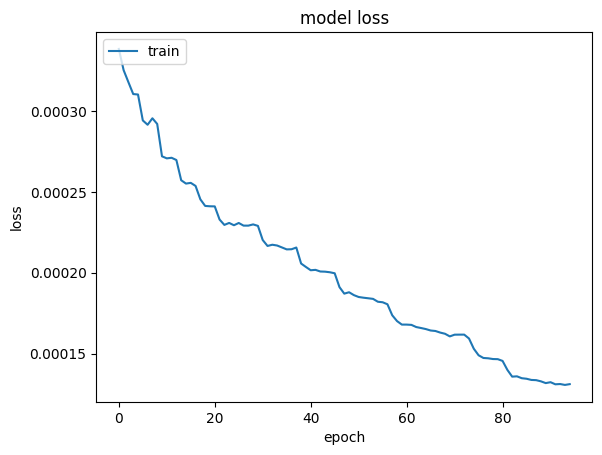

In [10]:
plt.plot(history.history["loss"][5:])
# plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [11]:
predictions = model.predict(x = X_train_array)
predictions

2514/2514 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


array([[0.8205275 ],
       [0.82941574],
       [0.8432876 ],
       ...,
       [0.7026182 ],
       [0.6263681 ],
       [0.7898762 ]], dtype=float32)

In [12]:
predicted_ratings = np.argmax(predictions, axis=1)

print(predicted_ratings.shape, predicted_ratings)
unique, counts = np.unique(predicted_ratings, return_counts=True)
# print(dict(zip(unique, counts)))
# train_data['rating'].value_counts()

# for (i, pred) in enumerate(predicted_ratings):
#     print(f"Predicted: {pred} Actual: {y_train_class[i]}")

def convert_rating(rating):
    return label_encoder.inverse_transform(rating)
    
converted_predicted_ratings = convert_rating(predicted_ratings)
converted_actual_ratings = convert_rating(y_train_class)

# for (i, pred) in enumerate(converted_predicted_ratings):
#     print(f"Predicted: {pred} Actual: {converted_actual_ratings[i]}")

correct, total = 0, 0
for (i, pred) in enumerate(converted_predicted_ratings):
    if pred == converted_actual_ratings[i]:
        correct += 1
    total += 1

print(f"Accuracy: {correct/total}")


(80419,) [0 0 0 ... 0 0 0]
Accuracy: 0.013218269314465488


# Item Recommendation

In [13]:
def unwatched_movies(ratings):
    all_movie_ids = set(ratings['movieId'])
    user_to_unwatched_movies = {}

    for user_id in ratings['userId'].unique():
        user = ratings[ratings['userId'] == user_id]
        watched_movies = set(user['movieId'])
        unwatched_movies = all_movie_ids - watched_movies
        user_to_unwatched_movies[user_id] = unwatched_movies

    return user_to_unwatched_movies

In [ ]:
def recommend_movies(model, user_to_idx, movie_to_idx, n=10):
    unwatched = unwatched_movies(train_data)
    recommendations = {}

    for user_id, movies in unwatched.items():
        user_idx = user_to_idx[user_id]
        movie_indices = [movie_to_idx[movie_id] for movie_id in movies]
        
        user_array = np.array([user_idx] * len(movie_indices))
        movie_array = np.array(movie_indices)
        
        predictions = model.predict([user_array, movie_array]).flatten()
        top_n_indices = np.argsort(predictions)[::-1][:n]

        top_n_movie_ids = [int(id_movie_mapping[movie_indices[i]]) for i in top_n_indices]
        print(f"User {user_id}: {top_n_movie_ids}")
        
        recommendations[user_id] = top_n_movie_ids

    return recommendations

top_10_recommendations = recommend_movies(model, user_id_mapping, movie_id_mapping, n=10)

In [ ]:
def enhanced_recommend_movies_v2(model, user_to_idx, movie_to_idx, train_data, n=10, 
                                 rating_threshold=3.5, min_ratings=10):
    """
    Enhanced recommendation function for the second version:
    1. Considers movie popularity and rating distribution
    2. Filters out movies with too few ratings
    3. Uses rating threshold to determine "liked" movies
    4. Implements candidate selection
    """
    # Calculate movie statistics (count, mean, std)
    movie_stats = train_data.groupby('movieId').agg({
        'rating': ['count', 'mean', 'std']
    }).droplevel(0, axis=1)
    
    # Filter movies with enough ratings
    valid_movies = set(movie_stats[movie_stats['count'] >= min_ratings].index)
    
    # Calculate user preferences (movies rated >= rating_threshold)
    user_preferences = {}
    for user_id in train_data['userId'].unique():
        user_ratings = train_data[train_data['userId'] == user_id]
        liked_movies = user_ratings[user_ratings['rating'] >= rating_threshold]['movieId']
        
        if len(liked_movies) > 0:
            user_preferences[user_id] = liked_movies.tolist()
    
    unwatched = unwatched_movies(train_data)
    recommendations = {}

    for user_id, movies in unwatched.items():
        # Only consider valid unwatched movies
        user_unwatched = set(movies).intersection(valid_movies)
        
        if not user_unwatched:
            continue
        
        user_idx = user_to_idx[user_id]
        movie_indices = [movie_to_idx[movie_id] for movie_id in user_unwatched]
        
        user_array = np.array([user_idx] * len(movie_indices))
        movie_array = np.array(movie_indices)
        
        # Get predictions for unwatched movies
        predictions = model.predict([user_array, movie_array]).flatten()
        
        # Calculate confidence and popularity scores
        predictions_with_scores = []
        for movie_id, pred_rating in zip(user_unwatched, predictions):
            movie_idx = movie_to_idx[movie_id]
            
            # Confidence score based on the number of ratings
            confidence = 1 - (1 / (1 + movie_stats.loc[movie_id, 'count'] / 100))
            
            # Popularity score normalized between 0 and 1
            popularity = movie_stats.loc[movie_id, 'count'] / movie_stats['count'].max()
            
            # Adjusted score
            adjusted_score = (0.7 * pred_rating + 
                              0.2 * confidence + 
                              0.1 * popularity)
            
            predictions_with_scores.append((movie_id, adjusted_score))
        
        # Sort by adjusted score and get top N
        top_n_movie_ids = [
            movie_id for movie_id, _ in sorted(predictions_with_scores, key=lambda x: x[1], reverse=True)[:n]
        ]
        
        recommendations[user_id] = top_n_movie_ids
        print(f"User {user_id}: {top_n_movie_ids}")
    
    return recommendations

# Example usage:
top_10_recommendations_v2 = enhanced_recommend_movies_v2(model, user_id_mapping, movie_id_mapping, train_data, n=10)

In [14]:
def enhanced_recommend_movies_v3(model, user_to_idx, movie_to_idx, train_data, n=10, 
                                 user_rating_threshold=None, min_ratings=10, popularity_weight=0.4, confidence_weight=0.3):
    """
    Further enhanced recommendation function:
    - User-specific rating thresholds
    - Personalized weighting based on user behavior
    - More sophisticated confidence scoring
    """
    # Calculate movie statistics (count, mean, std)
    movie_stats = train_data.groupby('movieId').agg({
        'rating': ['count', 'mean', 'std']
    }).droplevel(0, axis=1)
    
    # Filter movies with enough ratings
    valid_movies = set(movie_stats[movie_stats['count'] >= min_ratings].index)
    
    # Determine user-specific rating thresholds if not provided
    if user_rating_threshold is None:
        user_rating_threshold = {}
        for user_id in train_data['userId'].unique():
            user_ratings = train_data[train_data['userId'] == user_id]
            user_rating_threshold[user_id] = user_ratings['rating'].median()
    
    # Calculate user preferences (movies rated >= user-specific rating threshold)
    user_preferences = {}
    for user_id in train_data['userId'].unique():
        user_ratings = train_data[train_data['userId'] == user_id]
        liked_movies = user_ratings[user_ratings['rating'] >= user_rating_threshold[user_id]]['movieId']
        
        if len(liked_movies) > 0:
            user_preferences[user_id] = liked_movies.tolist()
    
    unwatched = unwatched_movies(train_data)
    recommendations = {}
    
    for user_id, movies in unwatched.items():
        if user_id not in user_preferences:
            continue  # Skip if there are no preferences
        
        user_unwatched = set(movies).intersection(valid_movies)
        if not user_unwatched:
            continue
        
        user_idx = user_to_idx[user_id]
        movie_indices = [movie_to_idx[movie_id] for movie_id in user_unwatched]
        
        user_array = np.array([user_idx] * len(movie_indices))
        movie_array = np.array(movie_indices)
        
        # Get predictions for unwatched movies
        predictions = model.predict([user_array, movie_array]).flatten()
        
        # Calculate personalized scores with weighted components
        predictions_with_scores = []
        for movie_id, pred_rating in zip(user_unwatched, predictions):
            movie_idx = movie_to_idx[movie_id]
            
            # Confidence scoring: Takes into account the user behavior and movie statistics
            confidence = 1 - (1 / (1 + movie_stats.loc[movie_id, 'count'] / 100))
            popularity = movie_stats.loc[movie_id, 'count'] / movie_stats['count'].max()
            
            # Weighted factors: Personal behavior, prediction accuracy, popularity
            adjusted_score = (confidence_weight * confidence + 
                              popularity_weight * popularity + 
                              (1 - popularity_weight - confidence_weight) * pred_rating)
            
            predictions_with_scores.append((movie_id, adjusted_score))
        
        # Sort by adjusted score and get top N recommendations
        top_n_movie_ids = [
            movie_id for movie_id, _ in sorted(predictions_with_scores, key=lambda x: x[1], reverse=True)[:n]
        ]
        
        recommendations[user_id] = top_n_movie_ids
        print(f"User {user_id}: {top_n_movie_ids}")
    
    return recommendations

# Example usage:
top_10_recommendations_v3 = enhanced_recommend_movies_v3(model, user_id_mapping, movie_id_mapping, train_data, n=10)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
User 1: [318, 296, 260, 589, 150, 4993, 858, 7153, 5952, 1210]
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
User 2: [296, 2571, 356, 260, 593, 1196, 2858, 4993, 110, 527]
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
User 3: [356, 318, 296, 32, 1270, 608, 2571, 589, 593, 1214]
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
User 4: [356, 318, 2571, 260, 110, 589, 4993, 2858, 527, 150]
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
User 5: [356, 2571, 593, 260, 2959, 480, 2858, 1198, 858, 1196]
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
User 6: [296, 2571, 260, 2959, 2858, 1198, 7153, 5952, 4993, 1196]
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
User 7: [318, 296, 2571, 110, 2959, 527, 480, 858, 1198, 589]
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
User 8: [356, 318, 2571, 260, 1196, 527, 2959, 4993, 2858, 858]
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
User 9: [356, 318, 296, 2571, 593, 260, 110, 1196, 480, 527]
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
User 10: [318, 2571, 260, 589, 480, 1198,

In [15]:
def dcg(recommended_movies, actual_movies):
    dcg_value = 0.0
    for i, movie in enumerate(recommended_movies):
        if movie in actual_movies:
            dcg_value += 1 / np.log2(i + 2)  
    return dcg_value

def idcg(actual_movies, length):
    idcg_value = 0.0
    for i in range(min(len(actual_movies), length)):
        idcg_value += 1 / np.log2(i + 2)
    return idcg_value

def recommendation_performance(recommendations, test_data):
    running_precision, running_recall, running_ndcg = 0, 0, 0

    for user_id, recommended_movies in recommendations.items():
        actual_movies = test_data[test_data['userId'] == user_id]['movieId']

        intersection = len(set(recommended_movies) & set(actual_movies))
        precision = (intersection / len(recommended_movies)) * 100
        recall = (intersection / len(actual_movies)) * 100

        running_precision += precision
        running_recall += recall

        dcg_value = dcg(recommended_movies, actual_movies)
        idcg_value = idcg(actual_movies, len(recommended_movies))
        ndcg = (dcg_value / idcg_value) * 100 if idcg_value > 0 else 0
        running_ndcg += ndcg

    precision = running_precision / len(recommendations)
    recall = running_recall / len(recommendations)
    f_measure = 2 * (precision * recall) / (precision + recall)
    ndcg = running_ndcg / len(recommendations)

    return precision, recall, f_measure, ndcg

print("Precision \t%.4f%%\nRecall \t\t%.4f%%\nF-Measure \t%.4f%%\nNDCG \t\t%.4f%%" % recommendation_performance(top_10_recommendations_v3, test_data))

Precision 	16.2459%
Recall 		7.0800%
F-Measure 	9.8620%
NDCG 		0.0481%
